In [2]:
# Importing the libraries

# General DS libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set_style(style='ticks')

# Machine Learning pre-processing libraries
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler

# Machine Learning analysis libraries
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn import tree

# Machine Learning algorithm post-processing libraries
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.cross_validation import train_test_split
from sklearn import model_selection
import sklearn.metrics

/Users/tsed/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Load stored DataFrame from data wrangling
%store -r recent_nyc

/Users/tsed/anaconda3/lib/python3.6/site-packages/pickleshare.py:99: FutureWarning: 'pandas.core' is private. Use 'pandas.Categorical'
  obj = pickle.loads(f.read())


# Prediction of Permit Issue Times

## Table of Contents
* [9. Framing the Problem](#9.-Framing-the-Problem)
* [10. Data Transformation](#10.-Data-Transformation)
* [11. Compare Machine Learning Models](#11.-Compare-Machine-Learning-Models)
* [12. Feature Importance](#12.-Feature-Importance)
* [13. Class Imbalance](#13.-Class-Imbalance)
* [14. Model Enhancements](#14.-Model-Enhancements)
* [15. Resampling (Optional)](#15.-Resampling-(Optional))
* [16. Limitations](#16.-Limitations)
* [17. Future Work](#17.-Future-Work)
* [18. Major Findings and Client Recommendations](#18.-Major-Findings-and-Client-Recommendations)
* [19. Acknowledgements](#19.-Acknowledgements)

## 9. Framing the Problem

Supervised classification algorithms will be used to classify the issue times into time ranges. A classification approach is used because regression-based approaches are sensitive to outliers, which are present in many of the independent variables.

The number of classes could largely affect model performance due to class imbalance. Binary class or three-class outcomes were considered for this project, although more classes may be used. The class time ranges were chosen to reduce class imbalance issues if possible, more specifically:

- Binary outcome:
    - class 0: 1 month to 2 months
    - class 1: > 2 months
- Multi-class outcome:
    - class 0: 1 month to 3 months
    - class 1: 3 months to 6 months
    - class 2: >6 months

Some classification algorithms to be explored include:
- Logistic Regression (LR)
- K-Nearest Neighbors (KNN)
- Classification and Regression Trees (CART)
- Support Vector Machine (SVM)
- Random Forest (RF)
- Naive Bayes (NB)
- Gradient Boosted Trees (XGBoost)

##  10. Data Transformation

Let's first perform some feature engineering and data transformation. The filing and job start day and month are added as new features to consider.

In [4]:
def get_day(row):
    """Extract day of the week"""
    day = row.dayofweek
    return day

def get_month(row):
    """Extract month"""
    month = row.month
    return month

# Convert to datetime
recent_nyc['job_start_date'] = pd.to_datetime(recent_nyc['job_start_date'],errors='coerce')

# Filing date feature engineering
recent_nyc['filing_day'] = recent_nyc.filing_date.apply(get_day)
recent_nyc['filing_month'] = recent_nyc.filing_date.apply(get_month)

# Job start date feature engineering
recent_nyc['job_start_day'] = recent_nyc.job_start_date.apply(get_day)
recent_nyc['job_start_month'] = recent_nyc.job_start_date.apply(get_month)

Let's transform the datatypes for efficiency based on domain knowledge and prior insight from the EDA stage.

In [5]:
# Convert to category data type
category_data_types = ['residential', 'bldg_type', 'permit_status', 'filing_status', 'permit_subtype', 
                       'permittee_license_type', 'nonprofit', 'nta_name', 'council_district', 
                       'census_tract', 'filing_month', 'filing_day', 'block', 'lot', 'community_board', 
                       'zip_code', 'job_start_month', 'job_start_day']
def convert_datatype(df, lst, dtype, num=False):
    if num==False:
        for i in lst:
            df[i] = df[i].astype(dtype)
    else:
        for i in lst:
            df[i] = pd.to_numeric(df['i'], errors='coerce')

convert_datatype(recent_nyc, category_data_types, dtype='category')

# Convert to DateTime data type
recent_nyc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17589 entries, 1 to 1107938
Data columns (total 32 columns):
borough                   17589 non-null category
job_doc_num               17589 non-null int64
job_type                  17589 non-null category
block                     17589 non-null category
lot                       17589 non-null category
community_board           17574 non-null category
zip_code                  17587 non-null category
bldg_type                 17586 non-null category
residential               10008 non-null category
work_type                 13825 non-null category
permit_status             17533 non-null category
filing_status             17589 non-null category
permit_type               17589 non-null category
permit_subtype            9717 non-null category
filing_date               17589 non-null datetime64[ns]
issuance_date             17589 non-null datetime64[ns]
expiration_date           17589 non-null datetime64[ns]
job_start_date           

NaNs will cause issues with many machine learning algorithms. Dummy variables were created for the NaNs in the categorical variables. Continuous variables, more specifically latitude and longitude, were imputed since there are only 23 out of 17589 records.

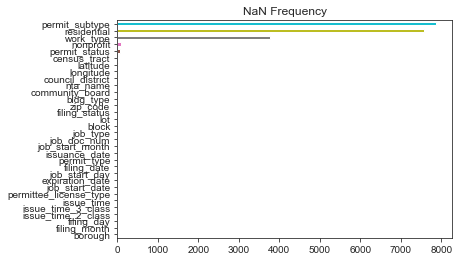

In [6]:
_ = pd.Series(recent_nyc.isnull().sum()).sort_values(ascending=True).plot.barh(width=0.5)
_ = plt.title('NaN Frequency')
plt.show()

In [7]:
recent_nyc.isnull().sum()

borough                      0
job_doc_num                  0
job_type                     0
block                        0
lot                          0
community_board             15
zip_code                     2
bldg_type                    3
residential               7581
work_type                 3764
permit_status               56
filing_status                0
permit_type                  0
permit_subtype            7872
filing_date                  0
issuance_date                0
expiration_date              0
job_start_date               0
permittee_license_type       0
nonprofit                   88
latitude                    23
longitude                   23
council_district            23
census_tract                23
nta_name                    23
issue_time                   0
issue_time_3_class           0
issue_time_2_class           0
filing_day                   0
filing_month                 0
job_start_day                0
job_start_month              0
dtype: i

In [8]:
X = pd.get_dummies(recent_nyc.loc[:, ['borough','job_type', 'bldg_type', 'work_type', 'permit_status',
                                        'filing_status', 'permit_type', 'permit_subtype',
                                        'permittee_license_type', 'nonprofit',
                                        'council_district', 'filing_day', 'filing_month', 'job_doc_num',
                                        'job_start_day', 'job_start_month', 'zip_code']], drop_first=True, dummy_na=True)
Y = recent_nyc['issue_time_2_class'].values
# Y = recent_nyc['issue_time_3_class'].values
X.info()
X.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17589 entries, 1 to 1107938
Columns: 354 entries, job_doc_num to zip_code_nan
dtypes: int64(1), uint8(353)
memory usage: 6.2 MB


,job_doc_num,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,borough_nan,job_type_A2,job_type_A3,job_type_DM,job_type_NB,...,zip_code_11433.0,zip_code_11434.0,zip_code_11435.0,zip_code_11436.0,zip_code_11691.0,zip_code_11692.0,zip_code_11693.0,zip_code_11694.0,zip_code_11697.0,zip_code_nan
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's first prepare our data for machine learning by transforming the categorical data by creating dummy variables. We do this using pd.get_dummies and setting 'drop_first=True' to avoid the dummy variable trap, i.e. we avoid feeding redundant information to the algorithm.

Now that all of the data is in numerical form we have some options to appropriately transform the data to ensure that the machine learning algorithms provide appropriate results. We may:
- Rescale data
- Standardize data
- Normalize data
- Binarize data

The data was standardize from the test and train splits.

In [9]:
X_columns = X.columns
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = imputer.fit_transform(X)
X = pd.DataFrame(X)
X.columns = X_columns

In [10]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# Scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## 11. Compare Machine Learning Models

Before tuning hyperparameters and other optimizations, it'd be a good idea to figure out which algorithm may work best for our given problem. Let's try a mixture of modeling types, e.g. linear and nonlinear functions or parametric and
nonparametric.

DUMMY: 0.531498 (0.010817)
LR: 0.625804 (0.014146)
KNN: 0.589946 (0.010558)
CART: 0.731632 (0.024989)
NB: 0.439163 (0.026764)
SVM: 0.630883 (0.013009)
RF: 0.671138 (0.015906)


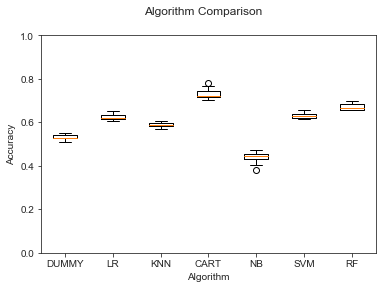

In [11]:
# Load dataset
X_compare = X_train
Y_compare = Y_train

# Prepare configuration for cross validation test harness
seed = 7

# Prepare models
models = []
models.append(('DUMMY', DummyClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_compare, Y_compare, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim(0, 1)
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.show()

## 12. Feature Importance

After splitting, let's identify the most important features in our dataset that contribute most to our prediction variable. Irrelevant features would decrease accuracy especially for linear algorithms, e.g. linear regression and logistic regression. Here are some other benefits:

- Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
- Improves Accuracy: Less misleading data means modeling accuracy improves.
- Reduces Training Time: Less data means that algorithms train faster.

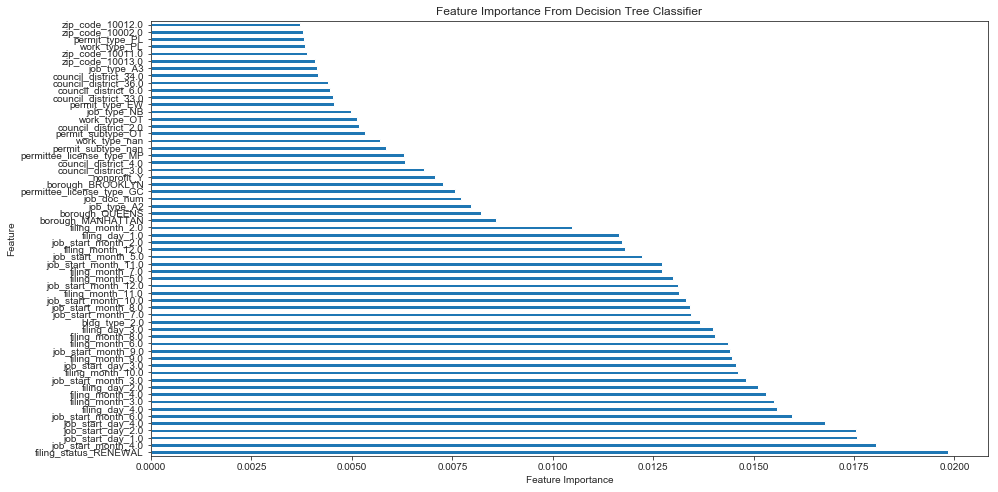

In [12]:
classifier = RandomForestClassifier(n_jobs = -1)
classifier.fit(X_train, Y_train)
feature_importance = pd.DataFrame(classifier.feature_importances_)
# feature_importance = feature_importance/np.max(feature_importance.iloc[:, 0])
feature_importance.index = X.columns
n_largest = feature_importance.nlargest(60, 0)

n_largest.plot.barh(width=0.5, legend=False, figsize=(15,8))
plt.title('Feature Importance From Decision Tree Classifier')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

## 13. Class Imbalance

The classes were purposefully chosen to reduce the effects of class imbalance.

Class 0: 11057
Class 1: 6532


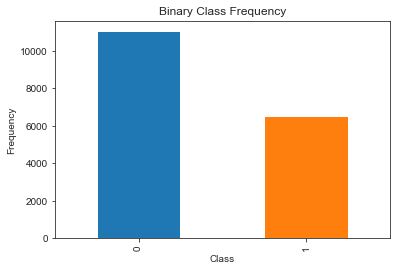

In [13]:
target_count = recent_nyc.issue_time_2_class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
target_count.plot(kind='bar', title='Binary Class Frequency')
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.show()

Class 0: 6128
Class 1: 5697
Class 2: 5764


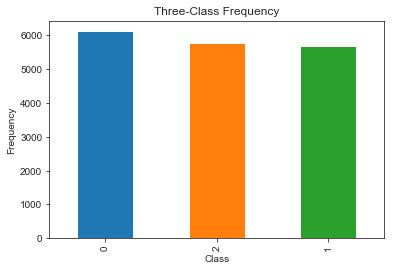

In [14]:
target_count = recent_nyc.issue_time_3_class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])

target_count.plot(kind='bar', title='Three-Class Frequency')
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.show()

## 14. Model Enhancements

Based on the initial non-optimized runs of several kinds of algorithms in section 11, running tree-based classifiers were focused on as they had the best initial metrics. 

Logistic regression would be a dubious choice of algorithm since there is a chance that records may not be independent since applicants may resubmit applications at a later date. Outliers are also present in the data and would require extensive pre-processing to remove in the time span of this project. Lastly, although a binary output was feature engineered, the problem could be framed as a multi-class problem with more than two classes, so it would be a good idea to leave that option available.

KNN and Naive Bayes did not have an acceptable improvement in accuracy compared to the dummy classifier so these were not considered further.

Some classification metrics to consider include:
* **Classification Accuracy**: Number of correct predictions made as a ratio of all predictions made
    * Note: Suitable when there are an equal number of observations in each class. Predictions and prediction errors are equally important  
* **Logarithmic Loss**: Evaluates the predictions of probabilities of membership to a given class. The scalar probability between 0 and 1 can be seen as a measure of confidence for a prediction by an algorithm. Predictions that are correct or incorrect are rewarded or punished proportionally to the confidence of the prediction.
    * Note: Smaller logloss is better with 0 representing a perfect logloss.
* **Area Under ROC Curve**: Evaluates a model's ability to discriminate between positive and negative classes
    * Note: Used for binary classification problems. 1.0 = Perfect, 0.5 = Random
* **Confusion Matrix**: Presents the accuracy of a model with two or more classes
* **Classification Report**: Displays the precision, recall, F1-score and support for each class

Starting with a Dummy Classifier, we may use this as a benchmark for other supervisied classification algorithms.

In [15]:
# K-Fold Cross-Validation
num_folds = 5
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
dc = DummyClassifier()
scoring = ['neg_log_loss', 'accuracy']
for score in scoring:
    results = cross_val_score(dc, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))
dc.fit(X_train, Y_train)
Y_pred = dc.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

neg_log_loss : -16.116 (0.291)
accuracy : 0.541 (0.007)
Classification Report: 
              precision    recall  f1-score   support

          0       0.63      0.64      0.63      2730
          1       0.39      0.37      0.38      1668

avg / total       0.54      0.54      0.54      4398
 



The Receiver Operator Characteristic (ROC) curve shows an almost 45 degree line, which is to be expected when a classifier is as good as flipping a coin.

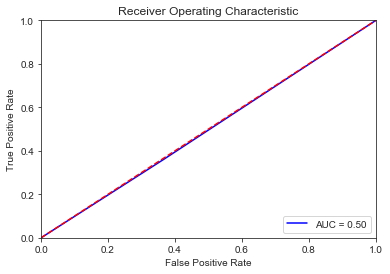

In [16]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = dc.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decision Trees are a non-parametric supervised learning method used for classification and regression. Their key advantage is that they can learn non-linear relationships, and are fairly robust to outliers. The issue is that unconstrained, individual trees are prone to overfitting because they can keep branching until a full tree is developed.

In [17]:
param_grid = {
    'max_depth': [50, 75, 100],
    'min_samples_leaf': [1, 2, 4, 8]
}

# K-Fold Cross-Validation
num_folds = 5
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
dtc = DecisionTreeClassifier()
dtc_grid = GridSearchCV(estimator = dtc, param_grid = param_grid, 
                     cv = num_folds, n_jobs = -1)
scoring = ['accuracy']
for score in scoring:
    results = cross_val_score(dtc_grid, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

dtc_grid.fit(X_train, Y_train)
Y_pred = dtc_grid.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

best_parameters = dtc_grid.best_params_
print(best_parameters)

accuracy : 0.735 (0.021)
Classification Report: 
              precision    recall  f1-score   support

          0       0.76      0.83      0.79      2730
          1       0.67      0.58      0.62      1668

avg / total       0.73      0.73      0.73      4398
 

{'max_depth': 50, 'min_samples_leaf': 4}


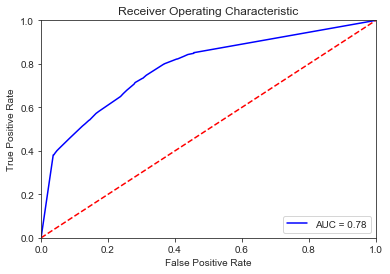

In [18]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = dtc_grid.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random forest classifiers are an ensemble of decision tree classifiers. They have the key advantages of computational efficiency and an ability to handle high dimensions well. Because randomness is introduced in the selection of records and features, the random forest reduces overfitting, which decision trees are more prone.

The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

In [20]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth':[100, 150, 200],
    'min_samples_leaf':[1, 2, 4]
}

# K-Fold Cross-Validation
num_folds = 5
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                     cv = num_folds, n_jobs = -1)
scoring = ['neg_log_loss', 'accuracy']
for score in scoring:
    results = cross_val_score(rfc_grid, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

rfc_grid.fit(X_train, Y_train)
Y_pred = rfc_grid.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

best_accuracy = rfc_grid.best_score_
best_parameters = rfc_grid.best_params_
print(best_accuracy, best_parameters)

neg_log_loss : -0.565 (0.010)
accuracy : 0.696 (0.011)
Classification Report: 
              precision    recall  f1-score   support

          0       0.70      0.92      0.80      2730
          1       0.73      0.36      0.48      1668

avg / total       0.71      0.71      0.68      4398
 

0.698961413084679 {'max_depth': 150, 'min_samples_leaf': 1, 'n_estimators': 100}


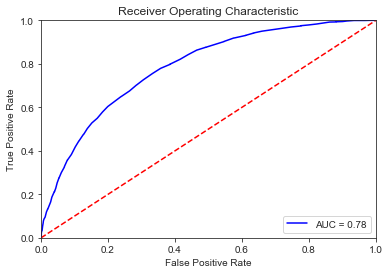

In [21]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = rfc_grid.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Gradient Boosted Trees are sequentially grown trees that aims to improve predictions from previously grown trees. In boosting, because the growth of a particular tree takes into account the other trees that have already been grown, smaller trees are typically sufficient. Using smaller trees can aid in interpretability as well; for instance, using stumps leads to an additive model.

Random Forest on the other hand typically does not use decision stumps, but uses rather complex trees.

https://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf

In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

param_grid = {
    'max_depth': [1, 3, 5],
    'n_estimators': [150, 200, 250]
    
}

# K-Fold Cross-Validation
num_folds = 5
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
xgb = XGBClassifier()

xgb_grid = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                     cv = num_folds, n_jobs = -1)
scoring = ['neg_log_loss', 'accuracy']
for score in scoring:
    results = cross_val_score(xgb_grid, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

xgb_grid.fit(X_train, Y_train)
Y_pred = xgb_grid.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

best_accuracy = xgb_grid.best_score_
best_parameters = xgb_grid.best_params_
print(best_accuracy, best_parameters)

neg_log_loss : -0.484 (0.017)
accuracy : 0.763 (0.013)
Classification Report: 
              precision    recall  f1-score   support

          0       0.77      0.89      0.83      2730
          1       0.76      0.57      0.65      1668

avg / total       0.77      0.77      0.76      4398
 

0.7577894018649078 {'max_depth': 5, 'n_estimators': 250}


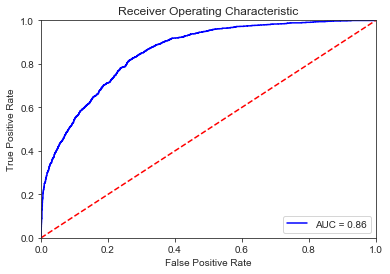

In [24]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = xgb_grid.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The F1 score and AUC of the ROC curve were used as the classification metrics. The F1 score ensures that each class has a balanced precision and recall. The AUC is insensitive to data sets with unbalanced class proportions and end users may want to adjust the decision thresholds based on their business needs. From the analysis, the XGBoost algorithm achieved the highest AUC of 0.86.

The business problem requires a mixture of interpretability and AUC since the end user may be a real estate company, homeowner or the NYC building department. For example, homeowners would probably just want a quick and highly accurate answer for the few properties they own. However, a real estate company may need interpretability slightly more than high AUC so they could better allocate resources at a more granular level for multiple properties.

Two models may be considered. Decision trees offer both interpretability and an acceptable AUC. However, XGBoost has the highest AUC in the analysis and tend to overcome overfitting at the cost of lower interpretability.

## 15. Resampling

Resampling may be used if classes are extremely unbalanced. For the tuned XGBoost, oversampling is the most beneficial for balancing the precision and recall in the two classes while maintaining a high score.

* **Oversampling**: Oversamples the minority class to the same frequency as the majority class

* **Undersampling**: Undersamples the majority class to the same frequency as the minority class

* **Synthetic Minority Over-sampling Technique (SMOTE)**: synthesize elements for the minority class, based on those that already exist. A point is randomly picked from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

* **Synthetic Minority Over-sampling Technique (SMOTE) w/ TOMEK links**: Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.



In [27]:
# Oversampling on training set
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, Y_ros = ros.fit_sample(X_train, Y_train)

# Undersampling on training set
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_rus, Y_rus = rus.fit_sample(X_train, Y_train)

# Synthetic Minority Over-sampling Technique (SMOTE) on training set
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_sm, Y_sm = smote.fit_sample(X_train, Y_train)

# Synthetic Minority Over-sampling Technique (SMOTE) with Tomek Links on training set
from imblearn.combine import SMOTETomek
smt = SMOTETomek(ratio='auto')
X_smt, Y_smt = smt.fit_sample(X_train, Y_train)

# K-Fold Cross-Validation
num_folds = 5
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
model = XGBClassifier(max_depth=5, n_estimators=250)

# Create resampling list to loop over
X_resamples = [(X_ros, Y_ros, 'Oversampling'), (X_rus, Y_rus, 'Undersampling'), 
               (X_sm, Y_sm, 'SMOTE'), (X_smt, Y_smt, 'SMOTETomek')]

# Extract accuracy, before/after class value counts, and classification report for each resampling technique
for X_resample in X_resamples:
    X_res, Y_res, technique = X_resample
    results = cross_val_score(model, X_res, Y_res, cv=kfold, scoring='accuracy')
    print(technique)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))
    model.fit(X_res, Y_res)
    print ("Distribution of class labels before resampling \n{}".format(Counter(Y_train)))
    print ("Distribution of class labels after resampling \n{}".format(Counter(Y_res)))
    Y_pred = model.predict(X_test)
    report = classification_report(Y_test, Y_pred)
    print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

Oversampling
accuracy : 0.737 (0.036)
Distribution of class labels before resampling 
Counter({0: 8327, 1: 4864})
Distribution of class labels after resampling 
Counter({1: 8327, 0: 8327})
Classification Report: 
              precision    recall  f1-score   support

          0       0.86      0.75      0.80      2730
          1       0.66      0.80      0.72      1668

avg / total       0.78      0.77      0.77      4398
 

Undersampling
accuracy : 0.533 (0.098)
Distribution of class labels before resampling 
Counter({0: 8327, 1: 4864})
Distribution of class labels after resampling 
Counter({0: 4864, 1: 4864})
Classification Report: 
              precision    recall  f1-score   support

          0       0.83      0.72      0.77      2730
          1       0.62      0.77      0.69      1668

avg / total       0.75      0.74      0.74      4398
 

SMOTE
accuracy : 0.817 (0.082)
Distribution of class labels before resampling 
Counter({0: 8327, 1: 4864})
Distribution of class labels a

In [28]:
# Visualize Decision Tree
dotfile = open("dtc.dot", 'w')
dt = tree.DecisionTreeClassifier(max_depth=75, min_samples_leaf=4)
dt.fit(X_train, Y_train)
tree.export_graphviz(dt, out_file=dotfile, feature_names=X.columns)
dotfile.close()

## 16. Limitations

- The building permit data did not include the cost of the proposed work. It may be the case that proposed work with large economic value to the city may get pushed ahead of the queue.

- Building permit expeditors typically reduces turnaround time for permit applications, which may introduce bias into the dataset.

## 17. Future Work

- Investigate framing the problem into a multi-class problem.

- Try incorporating other related datasets that may boost the signal, such as population and houeshold income datasets to better understand why location is a strong predictor. 


## 18. Major Findings and Client Recommendations

**Real Estate Developers / Homeowners:**

1) Location, time and work/permit type are some of the most important features in building issue times.

2) Use decision trees (real estate developer use case) or XGBoost (homeowner use case) to predict building permit issue time durations (medium or long duration) for non-trivial work items, e.g. new buildings and major alterations that will change the use, egress, or occupancy of the building.

3) For minor work, such as electrical work and demolition, involving single building departments expect issue times of less than a month.

**NYC Building Department:**

Minimal information is provided about issue times on the NYC building department website. One solution is to provide a web service that allows applicants to take an online survey, which provides a building permit issue time range based on what was checked on the survey. The issue time range could be based on Random Forest algorithm based on data from the past five years to ensure the result is robust.

## 19. Acknowledgements

The author would like to thank Springboard, especially his mentor for the advice and support throughout the capstone project.

Sources:
- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
- https://elitedatascience.com/imbalanced-classes
- https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
- https://www.kaggle.com/muonneutrino/new-york-city-census-data/version/2#nyc_census_tracts.csv
- https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf
- https://www.featuretools.com/
- https://beckernick.github.io/oversampling-modeling/
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- http://kseow.com/guides/
- https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/